<a href="https://colab.research.google.com/github/agustinfreiberger/Tesis_CNN/blob/master/Red_CNN_op.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [0]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [0]:
from google.colab import files
##El zip debe estar subido a content de colab
uploaded = files.upload()

In [0]:
import zipfile
zip_ref = zipfile.ZipFile("dataset-resized.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [0]:
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import resize
def imagerescaled(image):
  image_resized = resize(image, (image.shape[0] / 4, image.shape[1] / 4),
                         anti_aliasing=True)
  return image_resized

In [0]:
dirname = os.path.join(os.getcwd(), 'dataset-resized')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.extend(augmentedImg(imagerescaled(image)))
            cant=cant+3
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
dircount.append(cant)
dircount = dircount[1:]
#dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  /content/dataset-resized/
/content/dataset-resized/cardboard 1
/content/dataset-resized/glass 403
/content/dataset-resized/paper 501
/content/dataset-resized/plastic 594
/content/dataset-resized/metal 482
Directorios leidos: 5
Imagenes en cada directorio [404, 501, 594, 482, 409]
suma Total de imagenes en subdirs: 2390


In [0]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

Cantidad etiquetas creadas:  2390


In [0]:
materiales=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    materiales.append(name[len(name)-1])
    indice=indice+1

0 cardboard
1 glass
2 paper
3 plastic
4 metal


In [0]:
y = np.array(labels)
X = np.array(images) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  5
Output classes :  [0 1 2 3 4]


In [0]:
#hacer split por clase no por total

train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.3)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (1673, 96, 128, 3) (1673,)
Testing data shape :  (717, 96, 128, 3) (717,)


Text(0.5, 1.0, 'Ground Truth : 2')

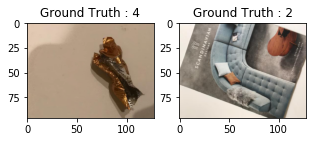

In [0]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

In [0]:
#train_X = np.reshape(train_X,(2021,96,128,1))
#test_X = np.reshape(test_X,(506,96,128,1))

train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

In [0]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 4
After conversion to one-hot: [0. 0. 0. 0. 1.]


In [0]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [0]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(1338, 96, 128, 3) (335, 96, 128, 3) (1338, 5) (335, 5)


In [0]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 100 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 32 # cantidad de imágenes que se toman a la vez en memoria

In [0]:
material_model = Sequential()
material_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(96,128,3)))
material_model.add(LeakyReLU(alpha=0.1))
material_model.add(MaxPooling2D((2, 2),padding='same'))
material_model.add(Dropout(0.5))

material_model.add(Flatten())
material_model.add(Dense(32, activation='linear'))
material_model.add(LeakyReLU(alpha=0.1))
material_model.add(Dropout(0.5))
material_model.add(Dense(nClasses, activation='softmax'))

In [0]:
material_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 96, 128, 32)       896       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 96, 128, 32)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 64, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 48, 64, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                3145760   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32)                0         
__________

In [0]:
material_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

In [0]:
material_train = material_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Train on 1338 samples, validate on 335 samples
Epoch 1/100
1338/1338 [==============================] - 1s 1ms/step - loss: 1.6039 - acc: 0.2272 - val_loss: 1.5934 - val_acc: 0.2687
Epoch 2/100
1338/1338 [==============================] - 1s 530us/step - loss: 1.5978 - acc: 0.2481 - val_loss: 1.5858 - val_acc: 0.2687
Epoch 3/100
1338/1338 [==============================] - 1s 512us/step - loss: 1.5889 - acc: 0.2564 - val_loss: 1.5744 - val_acc: 0.2687
Epoch 4/100
1338/1338 [==============================] - 1s 509us/step - loss: 1.5801 - acc: 0.2706 - val_loss: 1.5733 - val_acc: 0.2687
Epoch 5/100
1338/1338 [==============================] - 1s 503us/step - loss: 1.5749 - acc: 0.2571 - val_loss: 1.5622 - val_acc: 0.2925
Epoch 6/100
1338/1338 [==============================] - 1s 510us/step - loss: 1.5667 - acc: 0.2825 - val_loss: 1.5597 - val_acc: 0.3731
Epoch 7/100
1338/1338 [==============================] - 1s 502us/step - loss: 1.5639 - acc: 0.2915 - val_loss: 1.5546 - val_acc: 0.3

In [0]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
material_model.save("material_mnist.h5py")

In [0]:
test_eval = material_model.evaluate(test_X, test_Y_one_hot, verbose=1)

717/717 [==============================] - 0s 246us/step


In [0]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.3656227726650372
Test accuracy: 0.46443514656821056


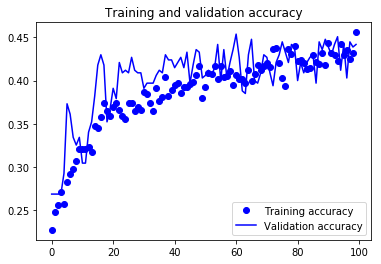

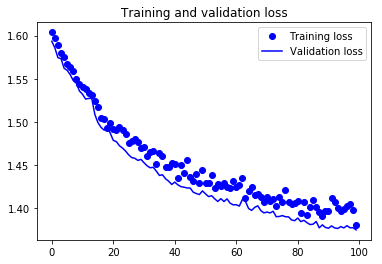

In [0]:
accuracy = material_train.history['acc']
val_accuracy = material_train.history['val_acc']
loss = material_train.history['loss']
val_loss = material_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
predicted_classes2 = material_model.predict(test_X)


In [0]:
predicted_classes=[]
for predicted_material in predicted_classes2:
    predicted_classes.append(predicted_material.tolist().index(max(predicted_material)))
predicted_classes=np.array(predicted_classes)

In [0]:
predicted_classes.shape, test_Y.shape

((717,), (717,))

Found 333 correct labels


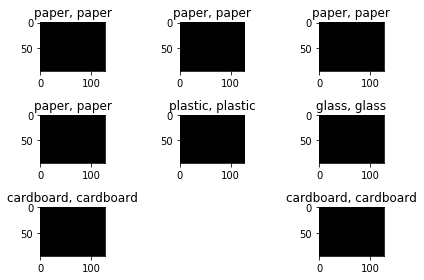

In [0]:
#Qué mejorar
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(96,128,3), cmap='gray')
    plt.title("{}, {}".format(materiales[predicted_classes[correct]],
                                                    materiales[test_Y[correct]]))

    plt.tight_layout()

Found 384 incorrect labels


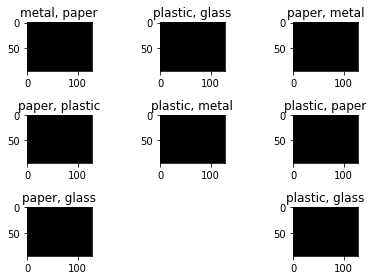

In [0]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(96,128,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(materiales[predicted_classes[incorrect]],
                                                    materiales[test_Y[incorrect]]))
    plt.tight_layout()

In [0]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.63      0.65      0.64       119
     Class 1       0.44      0.26      0.33       152
     Class 2       0.47      0.61      0.53       179
     Class 3       0.40      0.57      0.47       149
     Class 4       0.37      0.19      0.25       118

    accuracy                           0.46       717
   macro avg       0.46      0.46      0.44       717
weighted avg       0.46      0.46      0.45       717

